## Dependencies

In [1]:
import gc
import warnings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import tensorflow as tf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import datetime

In [3]:
def collect_gc():
    i = 0
    while i <= 6:
        print('collecting garbage...')
        print(gc.collect())
        i = i + 1
        
warnings.filterwarnings('ignore')

## Loading the Data

In [4]:
folder = '../input/g-research-crypto-forecasting/'

# Train data
base_train = pd.read_csv(folder+'train.csv', low_memory=False)

# Assets
asset_mapping = pd.read_csv(folder+'asset_details.csv', index_col=0)
asset_mapping = asset_mapping.reindex([i for i in range(14)])
asset_mapping

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


## Preprocessing Data

In [5]:
# converting the timestamp to minutes
base_train['time'] = pd.to_datetime(base_train['timestamp'], unit='s')
base_train.head(50)

base_train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
time              0
dtype: int64

In [6]:
bin_coin, btc, btc_cash, card, doge, eos_io, eth, eth_class, iota, ltc, maker, mon, stela, tron = [
    base_train.loc[base_train.Asset_ID == i] for i in range(14)]

assets = [bin_coin, btc, btc_cash, card, doge, eos_io, eth, eth_class, iota, ltc, maker, mon, stela, tron]

In [7]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

btc.set_index(btc.time, drop=True, inplace=True)

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


2021-11-24 00:50:16.760735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 00:50:16.762506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 00:50:16.763178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
print(btc.info())
btc_plt = btc.iloc[-8000:]

with tf.device('/GPU:0'):
    fig = go.Figure(data=go.Ohlc(x=btc_plt.time,
                open=btc_plt.Open,
                high=btc_plt.High,
                low=btc_plt.Low,
                close=btc_plt.Close))
    fig.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1956282 entries, 2018-01-01 00:01:00 to 2021-09-21 00:00:00
Data columns (total 11 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  int64         
 1   Asset_ID   int64         
 2   Count      float64       
 3   Open       float64       
 4   High       float64       
 5   Low        float64       
 6   Close      float64       
 7   Volume     float64       
 8   VWAP       float64       
 9   Target     float64       
 10  time       datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 179.1 MB
None


2021-11-24 00:50:16.854719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 00:50:16.855710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 00:50:16.856430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 00:50:16.857054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
# Handling missing Values
eth = base_train.loc[base_train['Asset_ID'] == 6]
eth.set_index(eth.time, drop=True, inplace=True)

btc.isnull().sum()

btc.fillna(method='ffill', inplace=True)
eth.fillna(method='ffill', inplace=True)
eth.isnull().sum()

timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
time         0
dtype: int64

## Analysis and Visualization

### Seasonality and Trend

  Binance Coin  


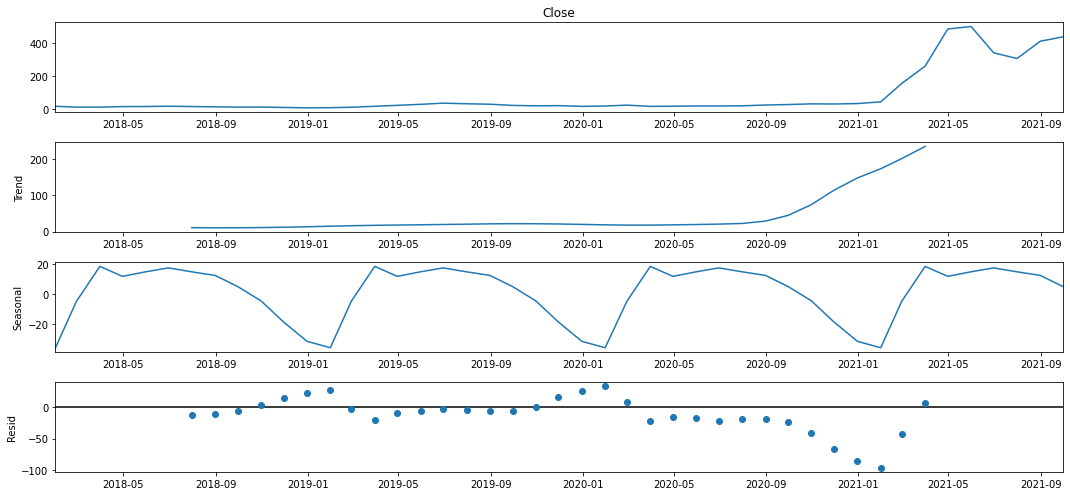





  Bitcoin  


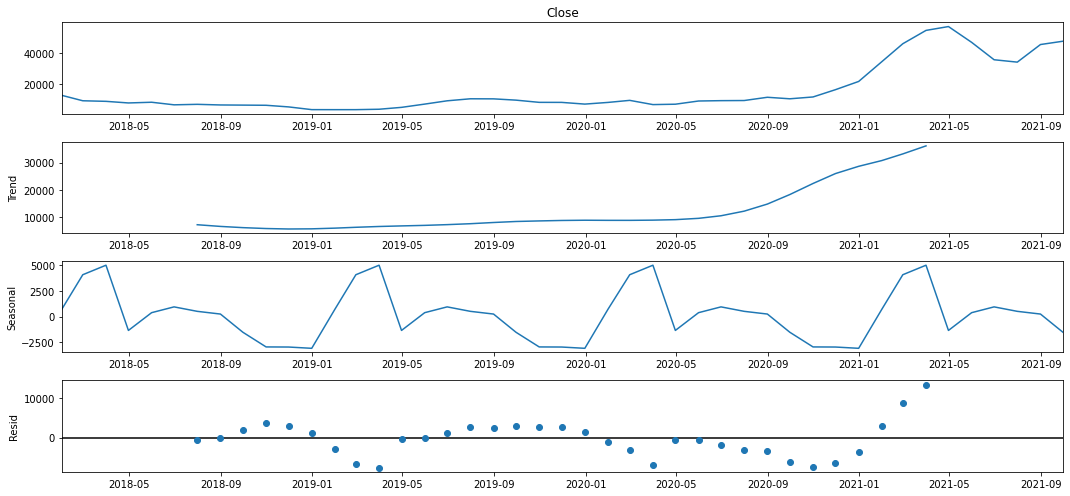





  Bitcoin Cash  


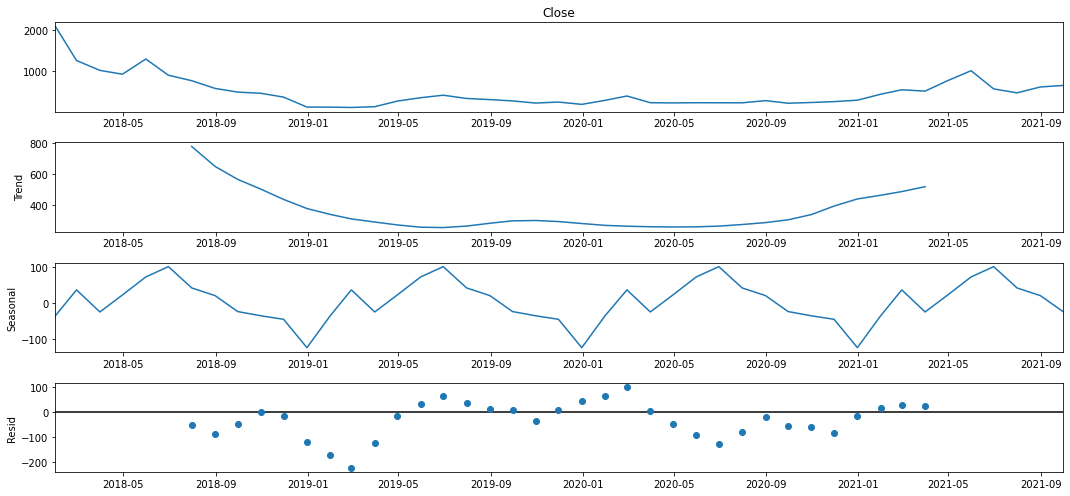





  Cardano  


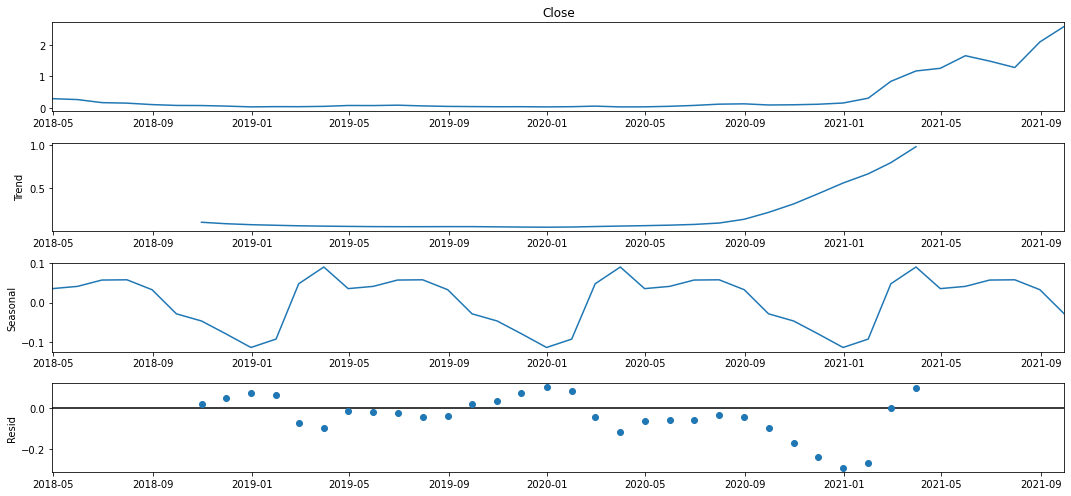





  Dogecoin  


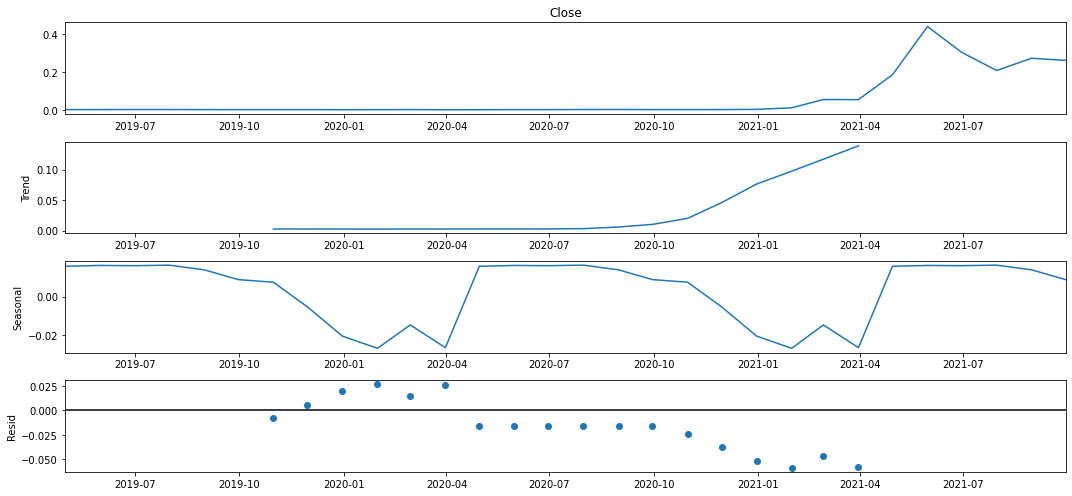





  EOS.IO  


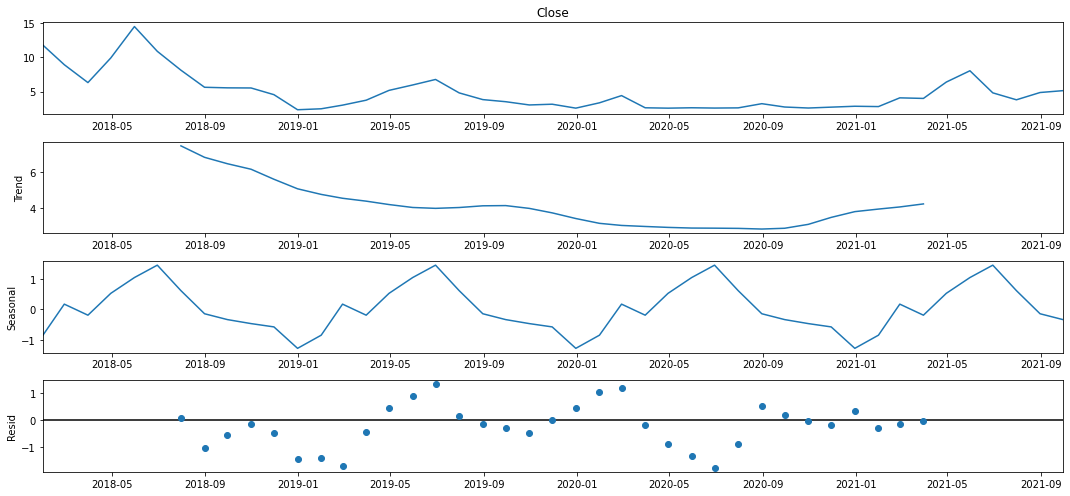





  Ethereum  


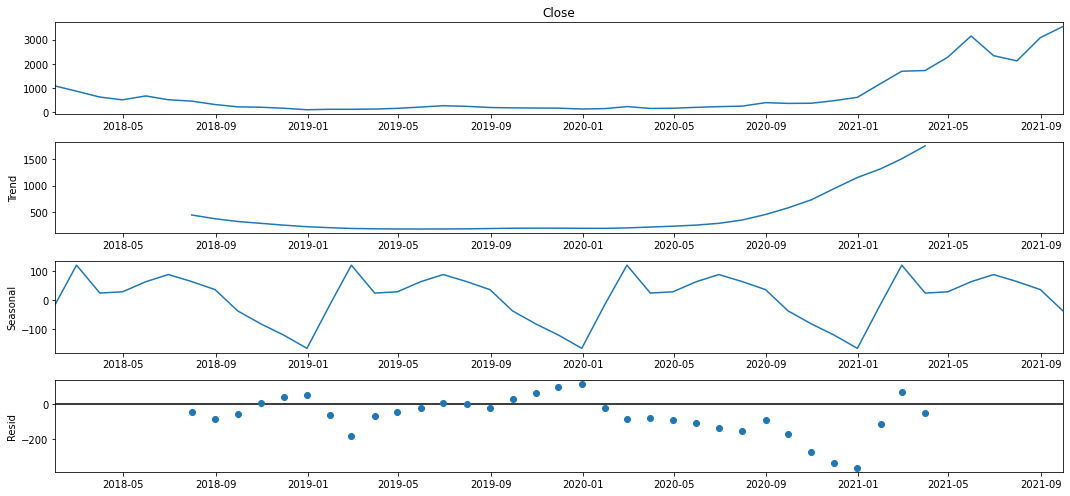





  Ethereum Classic  


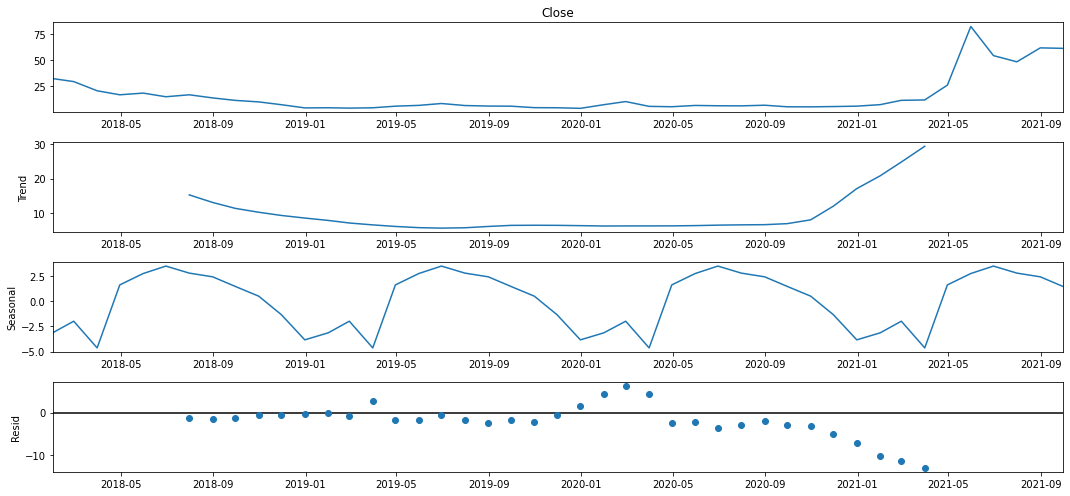





  IOTA  


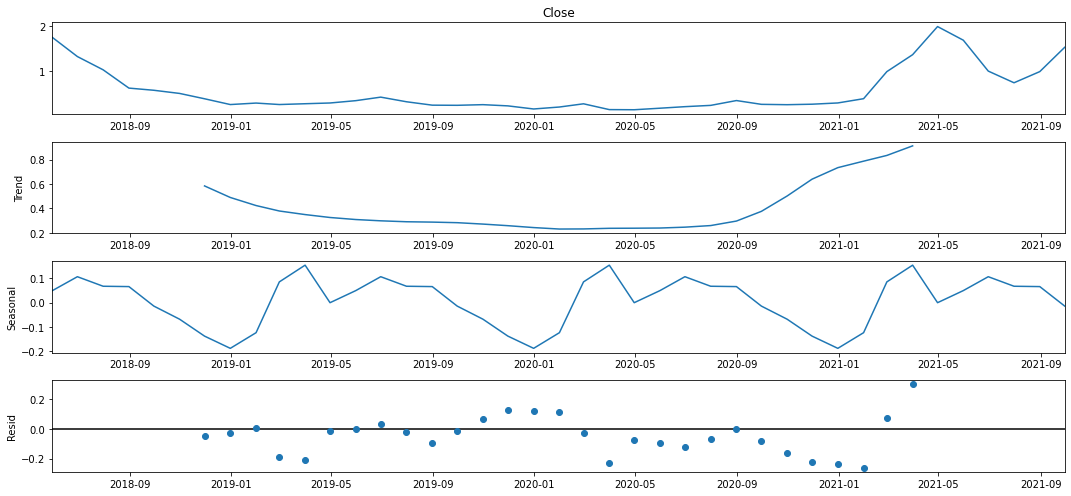





  Litecoin  


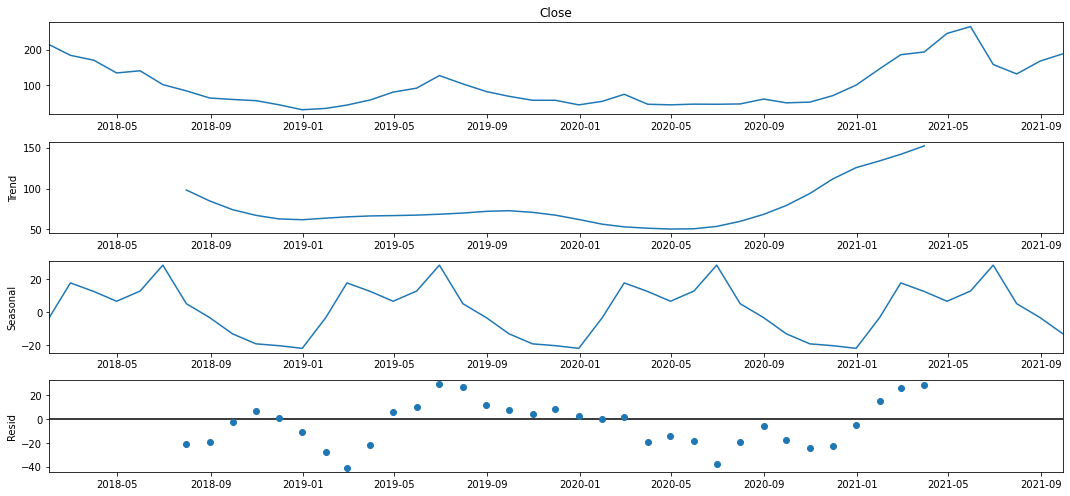





  Maker  


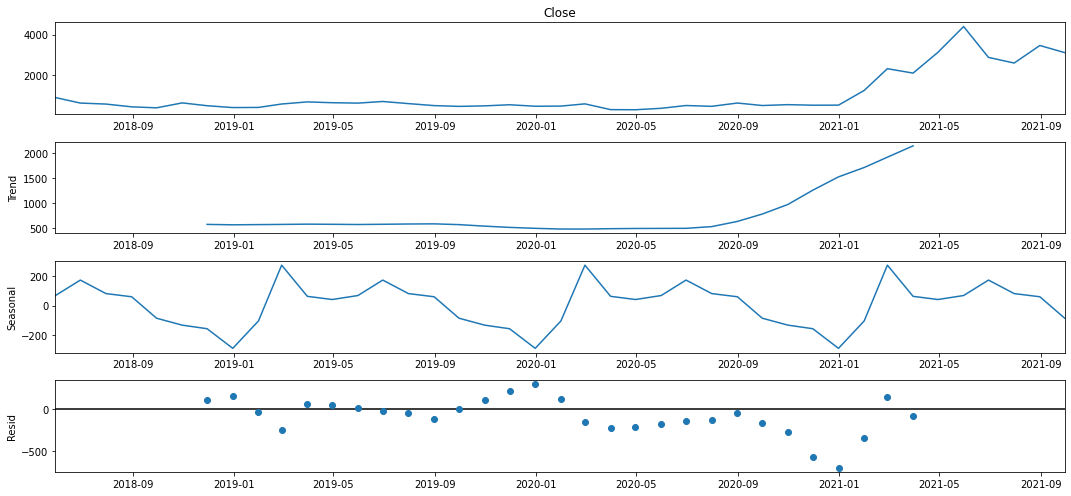





  Monero  


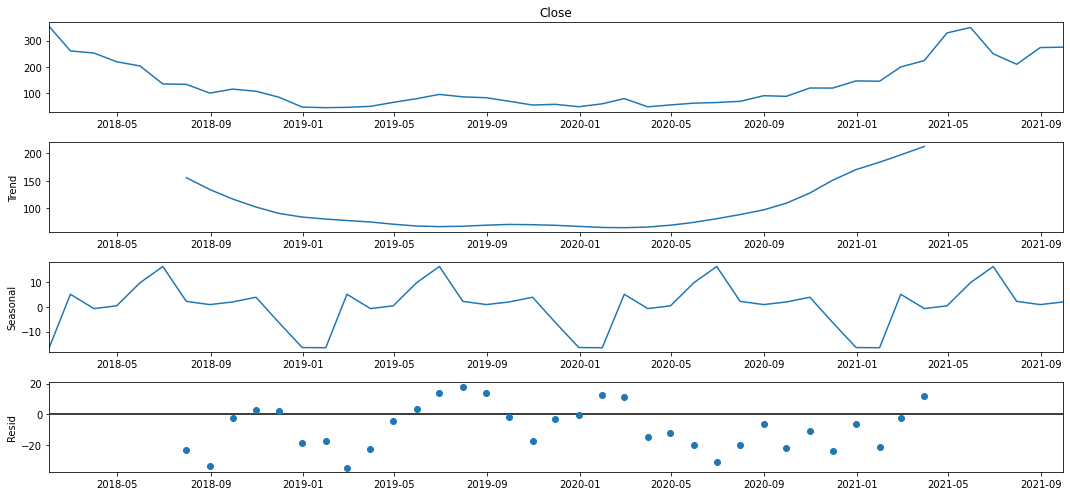





  Stellar  


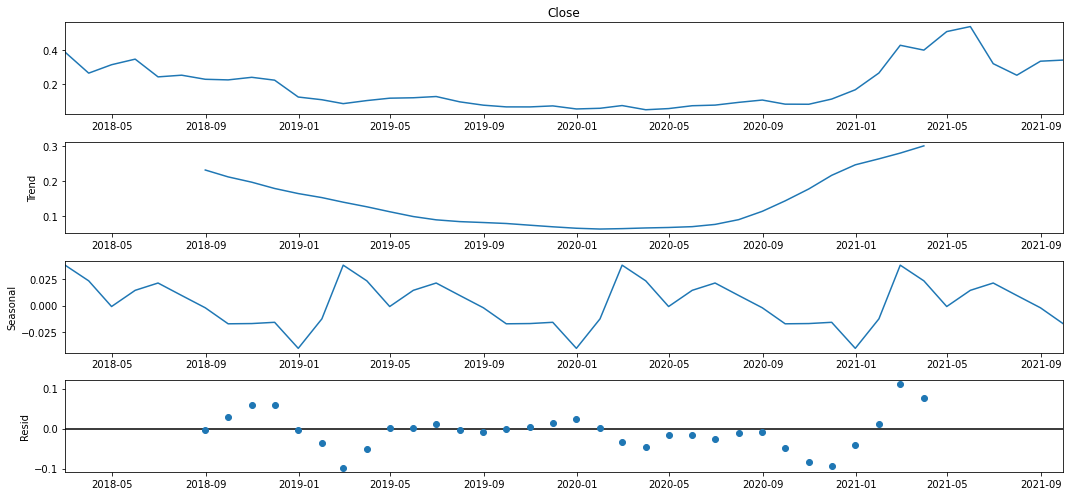





  TRON  


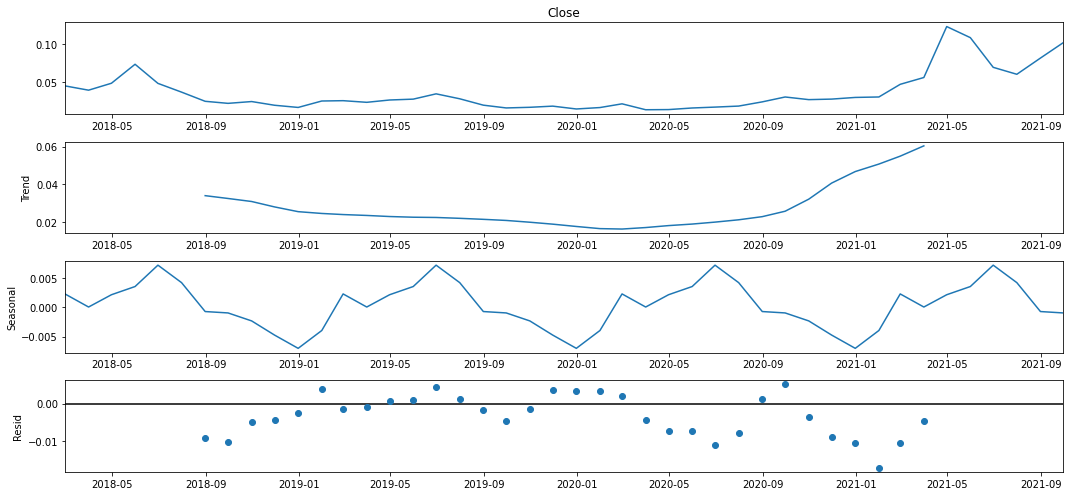

In [10]:
def decompose(price):
    rcParams['figure.figsize'] = 15, 7
    decomp_series = sm.tsa.seasonal_decompose(price, model='addictive')
    decomp_series.plot()
    plt.show()

for count, asset in enumerate(assets):
    asset2 = asset.set_index(asset.time)
    print(f' \033[92m \033[1m{asset_mapping.Asset_Name[count]}\033[1m \033[92m ')
    decompose(asset2.Close.resample('M').mean())
    print('\n');print('\n')

### Stationarity Test

In [11]:
def stationarity_test(col):
    
    print('--------------Stationarity Test--------------')
    adf_result = adfuller(col)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('No. of lags used:', adf_result[2])
    print('No. of observations used :', adf_result[3])
    if adf_result[1] < 0.05:
        print('TSD is Stationary')
    else:
        print('TSD is not Stationary')
    print( 'Critical Values:' )
    for k, v in adf_result[4].items():
        print( f' {k} : {v} ' )
    print('\n')

to_datetime = lambda s: pd.to_datetime(s, unit='s')
for a in assets:
    a.index = to_datetime(a.index)
    
for count, asset in enumerate(assets):
    print(asset_mapping.Asset_Name[count])
    stationarity_test(asset.Close.resample('D').mean())

Binance Coin
--------------Stationarity Test--------------
ADF Statistic: -0.5681825815493382
p-value: 0.8780106152419421
No. of lags used: 9
No. of observations used : 271
TSD is not Stationary
Critical Values:
 1% : -3.4547128138328875 
 5% : -2.8722649771800155 
 10% : -2.5724850011573914 


Bitcoin
--------------Stationarity Test--------------
ADF Statistic: -0.5461715992044652
p-value: 0.8826871898427194
No. of lags used: 10
No. of observations used : 1349
TSD is not Stationary
Critical Values:
 1% : -3.4352067731212785 
 5% : -2.863684892975246 
 10% : -2.5679119438718847 


Bitcoin Cash
--------------Stationarity Test--------------
ADF Statistic: -3.6696939341174257
p-value: 0.00456020319300783
No. of lags used: 16
No. of observations used : 264
TSD is Stationary
Critical Values:
 1% : -3.455365238788105 
 5% : -2.8725510317187024 
 10% : -2.5726375763314966 


Cardano
--------------Stationarity Test--------------
ADF Statistic: 2.2133944466639646
p-value: 0.9988933463680763
No.

In [12]:
collect_gc()

collecting garbage...
34885
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0


### Price Change

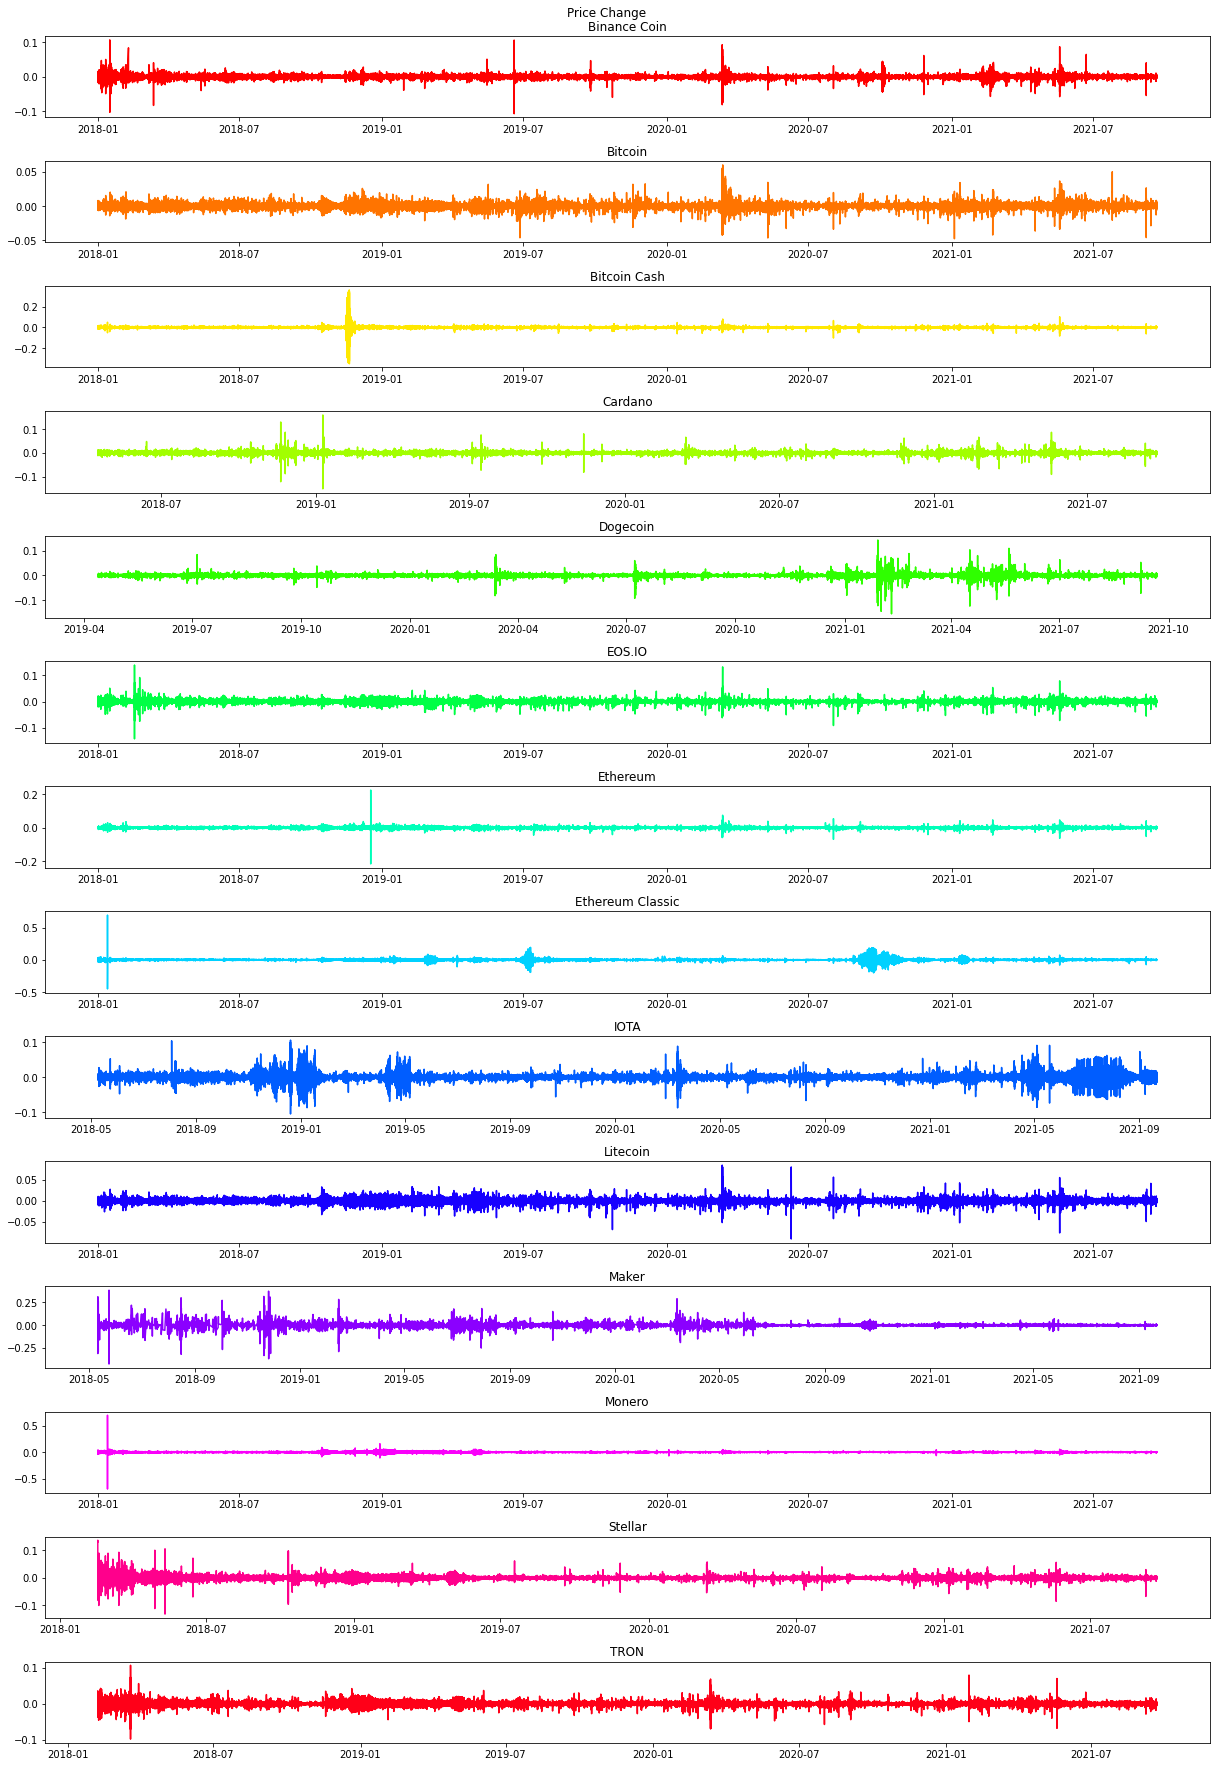

In [13]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(len(assets))

def diff(tsd, periods=1):
    return np.log(tsd).diff(periods=periods)

fig, ax = plt.subplots(len(assets), 1, figsize=(17, 25))
for count, asset in enumerate(assets):
    ax[count].plot(asset.time[1:], diff(asset.Close)[1:], c=cmap(count))
    ax[count].set_title(asset_mapping.Asset_Name[count])

plt.suptitle('Price Change \n')
plt.tight_layout()
plt.show()

In [14]:
for count, asset in enumerate(assets):
    print(asset_mapping.Asset_Name[count])
    stationarity_test(diff(asset.Close).resample('D').mean())

Binance Coin
--------------Stationarity Test--------------
ADF Statistic: -10.424959841024124
p-value: 1.6669637757617006e-18
No. of lags used: 1
No. of observations used : 279
TSD is Stationary
Critical Values:
 1% : -3.4540076534999957 
 5% : -2.8719557347997178 
 10% : -2.5723200648758366 


Bitcoin
--------------Stationarity Test--------------
ADF Statistic: -23.69120887916084
p-value: 0.0
No. of lags used: 1
No. of observations used : 1358
TSD is Stationary
Critical Values:
 1% : -3.4351745242248715 
 5% : -2.8636706623947417 
 10% : -2.567904365598721 


Bitcoin Cash
--------------Stationarity Test--------------
ADF Statistic: -16.31828321994945
p-value: 3.146157374436604e-29
No. of lags used: 0
No. of observations used : 280
TSD is Stationary
Critical Values:
 1% : -3.453922368485787 
 5% : -2.871918329081633 
 10% : -2.5723001147959184 


Cardano
--------------Stationarity Test--------------
ADF Statistic: -6.31546045355472
p-value: 3.158619015192796e-08
No. of lags used: 4
No.

### Autocorrelation and Partial Autocorrelation

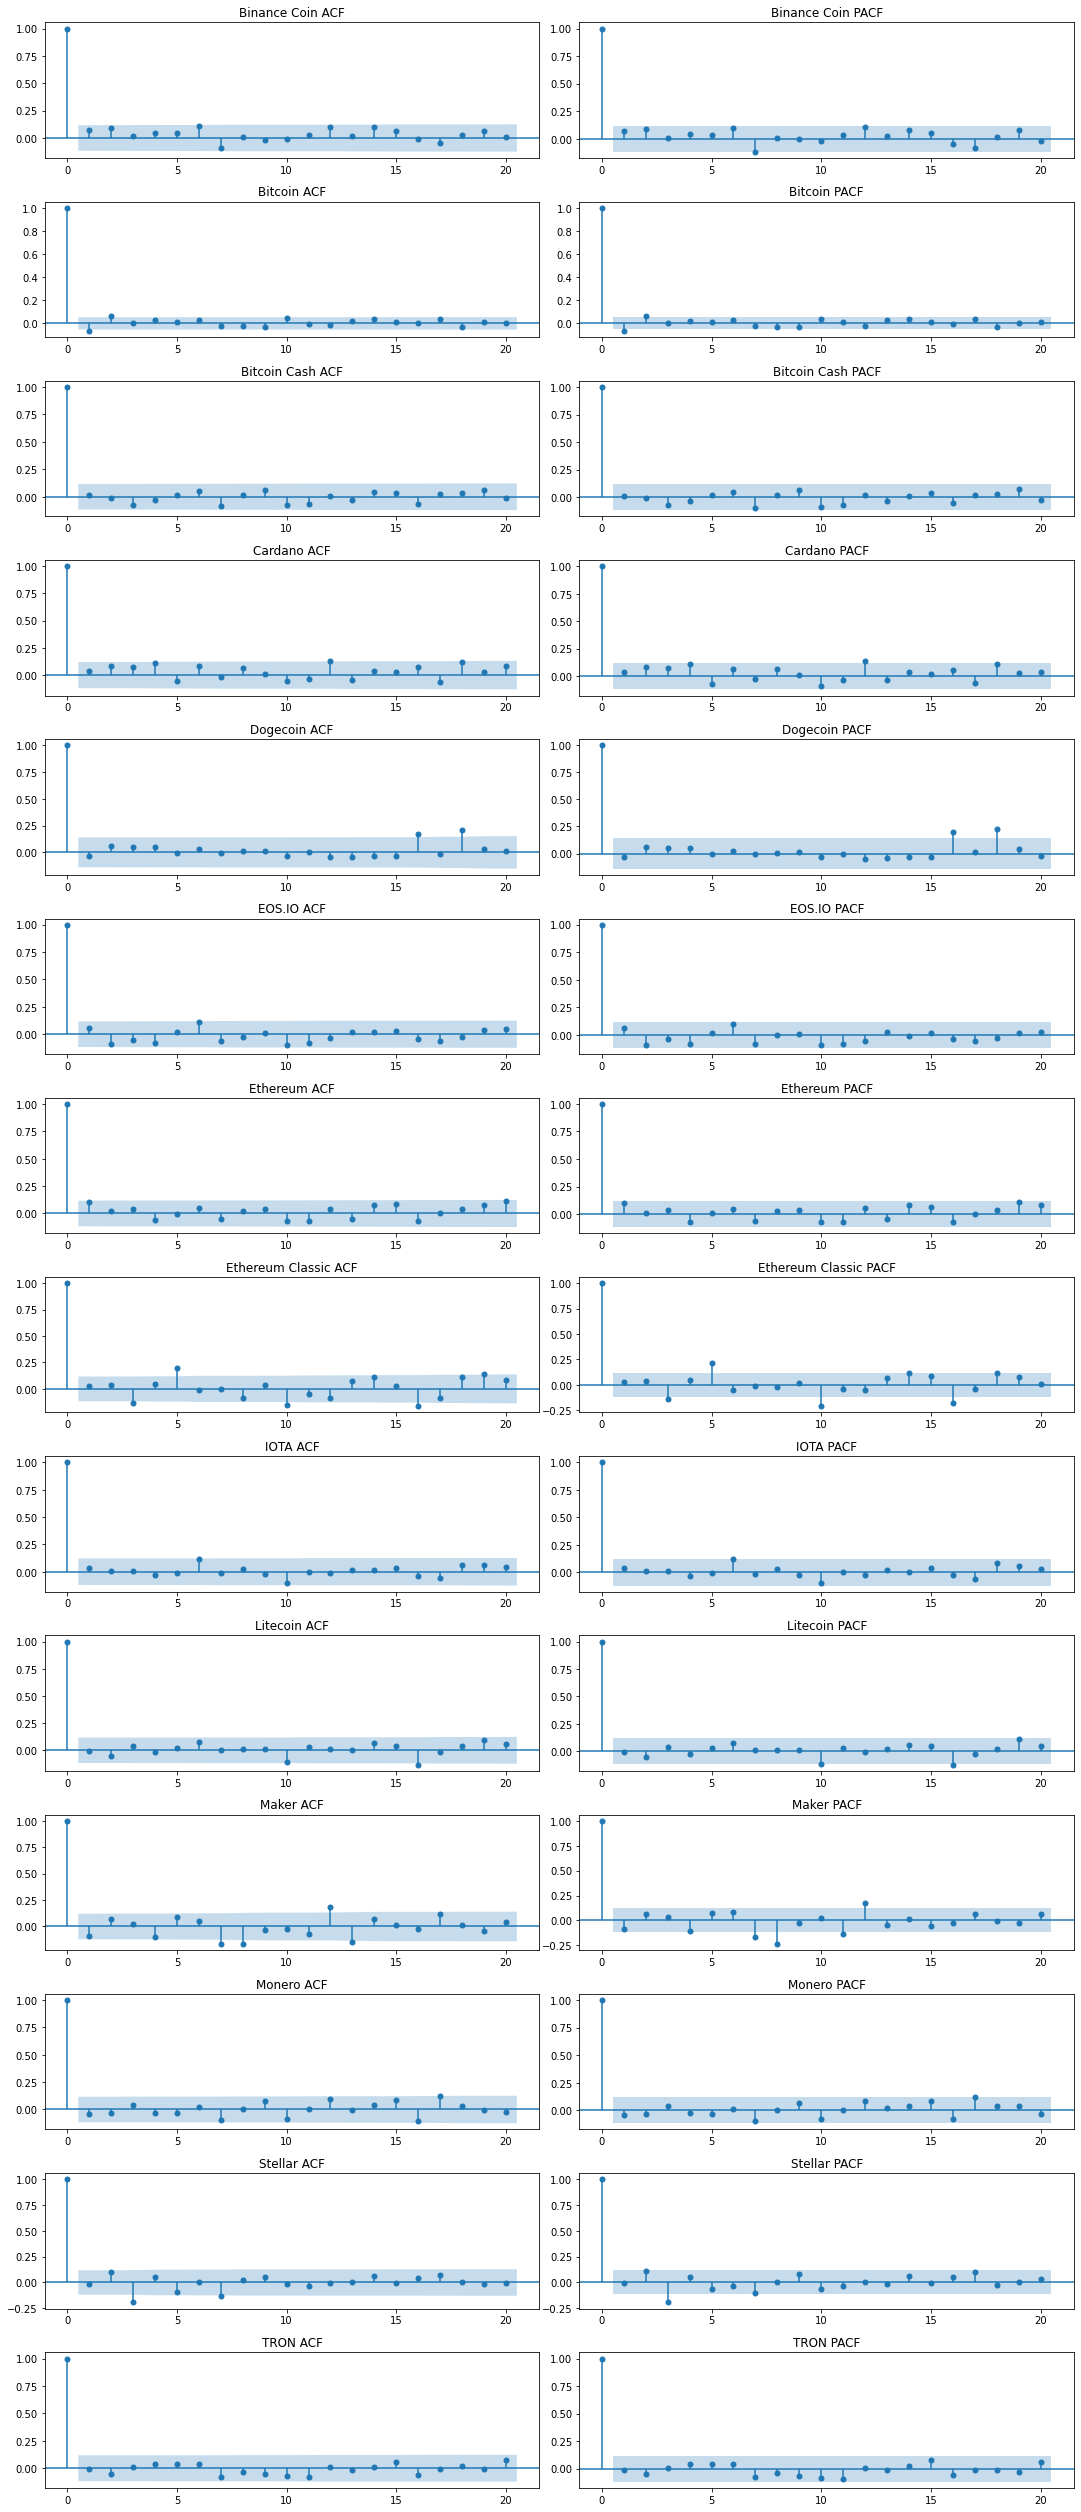

In [15]:
fig, axes = plt.subplots(len(assets), 2, figsize=(15, 35))

for count, asset in enumerate(assets):
    fig = plot_acf(diff(asset.Close)[1:].resample('D').mean(), lags=20, ax=axes[count, 0])
    fig = plot_pacf(diff(asset.Close)[1:].resample('D').mean(), lags=20, ax=axes[count, 1])
    axes[count, 0].set_title(f'{asset_mapping.Asset_Name[count]} ACF')
    axes[count, 1].set_title(f'{asset_mapping.Asset_Name[count]} PACF')

plt.tight_layout()
plt.show()

### Checking for correlation between assets

#### 2018-2021

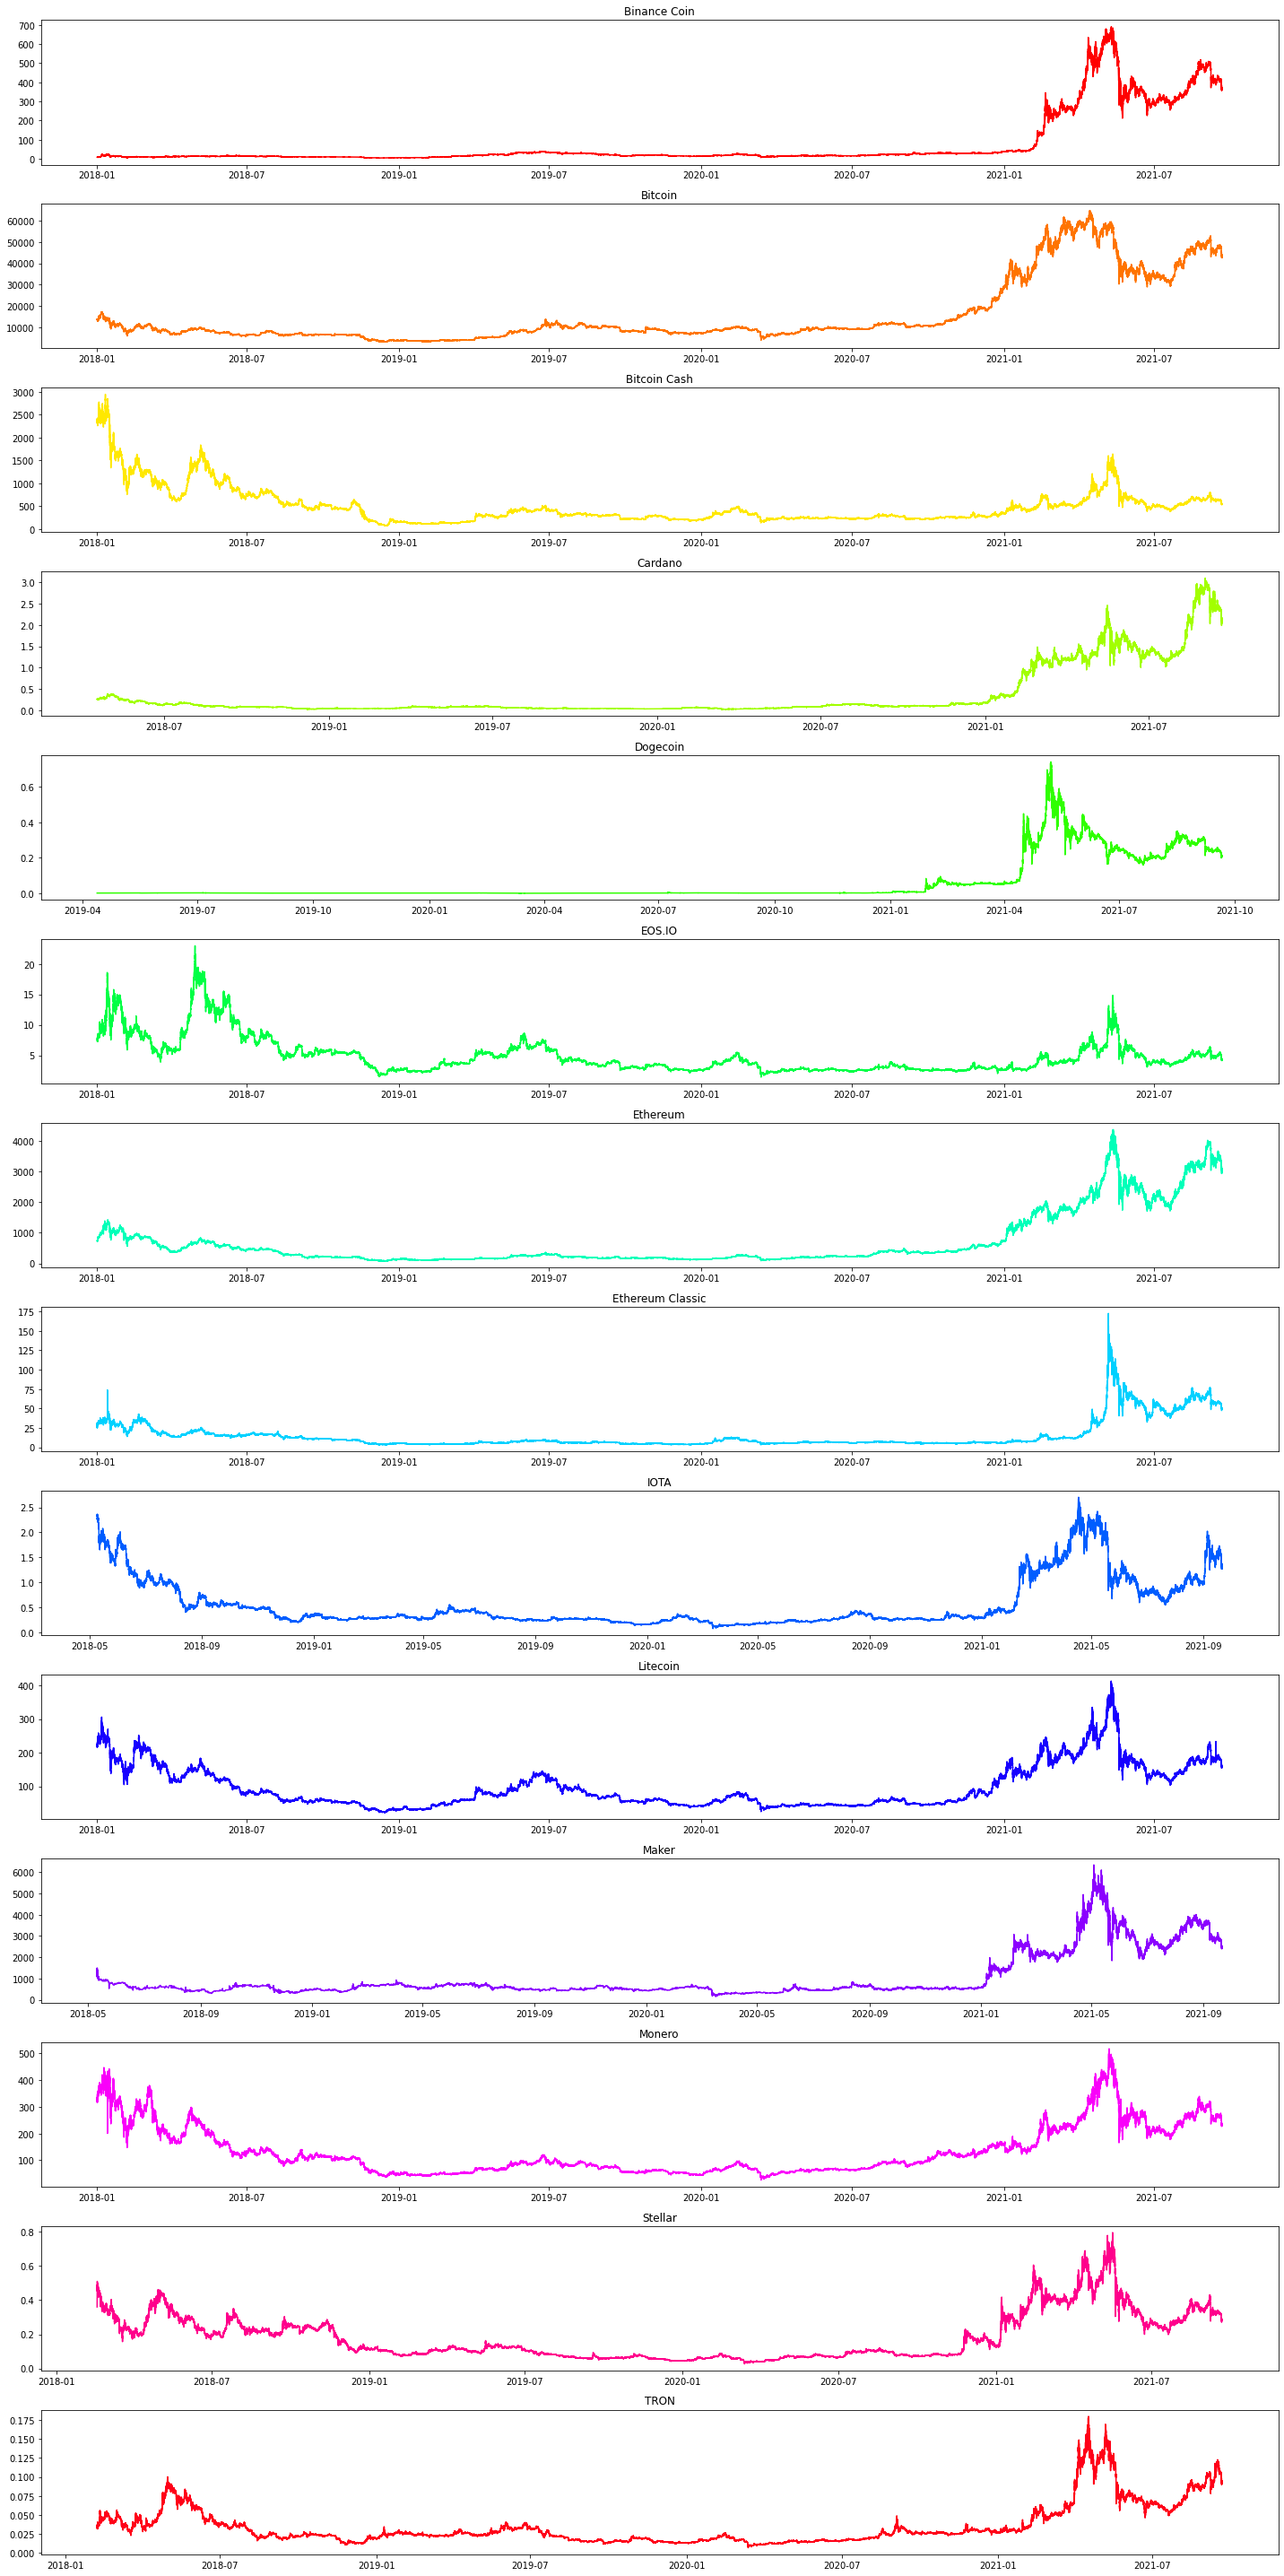

In [16]:
fig, axes = plt.subplots(len(assets), 1, figsize=(20, 40))

for count, asset in enumerate(assets):
    axes[count].plot(asset.time, asset.Close, color=cmap(count))
    axes[count].set_title(asset_mapping.Asset_Name[count])

plt.tight_layout()
plt.show()

#### September 2021

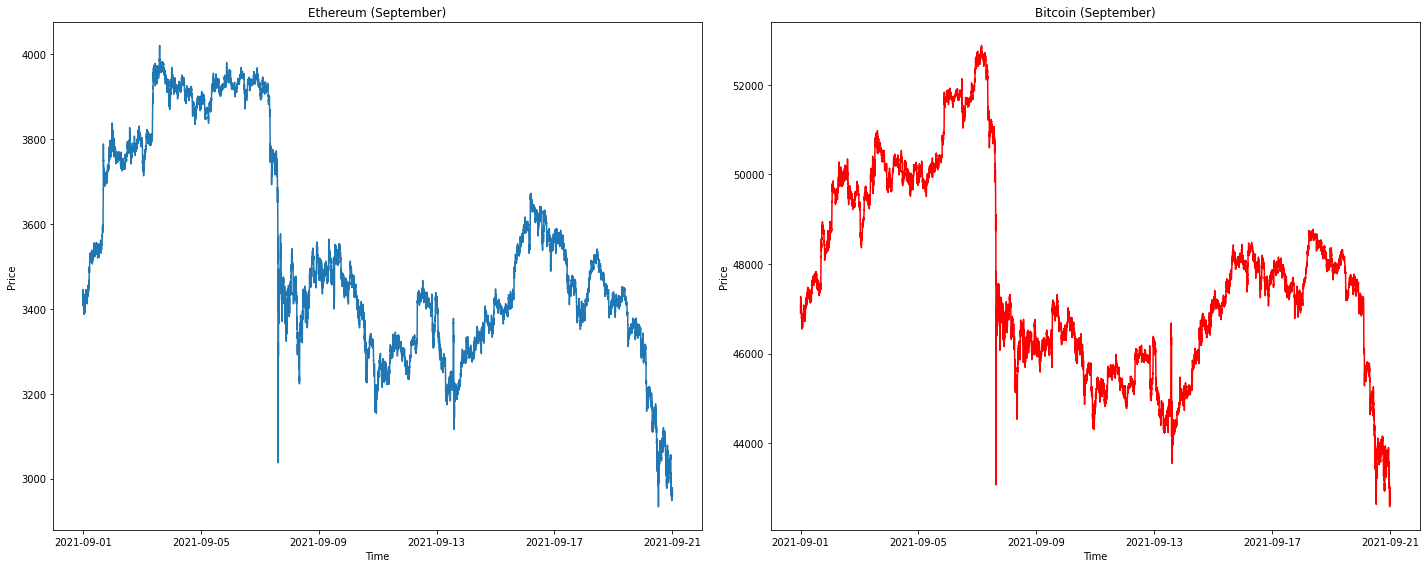

In [17]:
# 1 Month Plot
btc_sep = btc.loc['2021-09-01 00:01:00':'2021-09-30 00:01:00']
eth_sep = eth.loc['2021-09-01 00:01:00':'2021-09-30 00:01:00']

fig = plt.figure(figsize=(20, 8))
fig.add_subplot(121)
plt.title('Ethereum (September)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(eth_sep.time, eth_sep.Close)

fig.add_subplot(122)
plt.title('Bitcoin (September)')
plt.plot(btc_sep.time, btc_sep.Close, color='r')
plt.xlabel('Time')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [18]:
collect_gc()

collecting garbage...
82671
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0
collecting garbage...
0


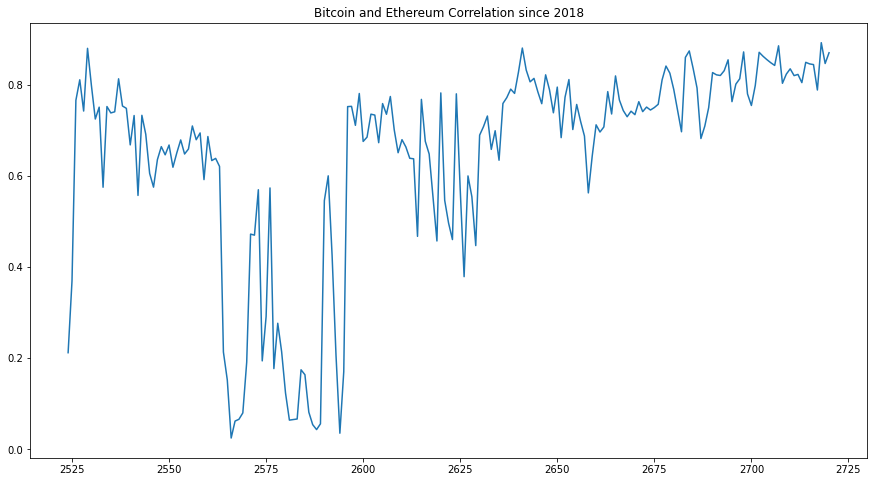

In [19]:
btc_change = diff(btc.Close)[1:].rename('Bitcoin')
eth_change = diff(eth.Close)[1:].rename('Etheruem')
asset_corr = pd.concat([btc_change, eth_change], axis=1)

to_timestamp = lambda a: [time.mktime(t.timetuple()) for t in a]
asset_corr.index = to_timestamp(asset_corr.index)
corr = asset_corr.groupby(asset_corr.index//(10000*60)).corr().loc[:,"Bitcoin"].loc[:,"Etheruem"]
rcParams['figure.figsize'] = 15, 8
corr.plot()
plt.title('Bitcoin and Ethereum Correlation since 2018')
plt.show()